In [13]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

In [14]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az

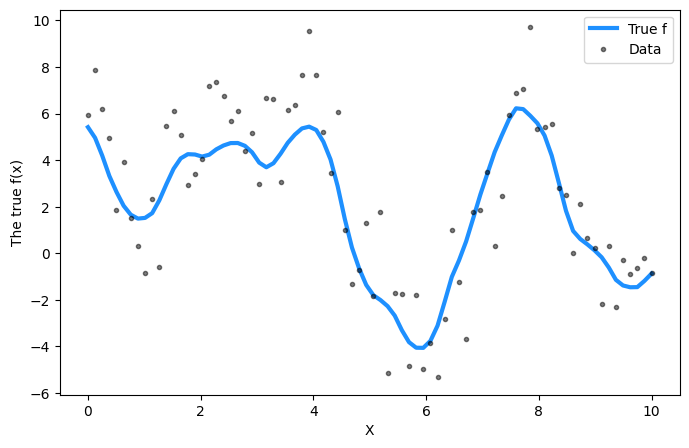

In [15]:
# Training data
n = 80 
X = np.linspace(0, 10, n)[:, None]  

# Define the true covariance function and its parameters
ell_true = 1.0
eta_true = 3.0
cov_func = eta_true**2 * pm.gp.cov.Matern52(1, ell_true)
mean_func = pm.gp.mean.Zero()
f_true = np.random.multivariate_normal(
    mean_func(X).eval(), cov_func(X).eval() + 1e-8 * np.eye(n), 1
).flatten()
sigma_true = 2.0

# True signal is corrupted by random noise
y = f_true + sigma_true * np.random.randn(n)

## Plot the data and the unobserved latent function
fig = plt.figure(figsize=(8, 5))
ax = fig.gca()
ax.plot(X, f_true, "dodgerblue", lw=3, label="True f")
ax.plot(X, y, "ok", ms=3, alpha=0.5, label="Data")
ax.set_xlabel("X")
ax.set_ylabel("The true f(x)")
plt.legend();

In [16]:
with pm.Model() as model:
    ell = pm.Gamma("ell", alpha=2, beta=1)
    eta = pm.HalfCauchy("eta", beta=5)

    cov = eta**2 * pm.gp.cov.Matern52(1, ell)
    
    gp = pm.gp.Marginal(cov_func=cov)

    sigma = pm.HalfCauchy("sigma", beta=5)
    y_ = gp.marginal_likelihood("y", X=X, y=y, sigma=sigma)

    with model:
        marginal_post = pm.sample(draws=5000, chains=2) # by default uses a Normal proposal
        
    with model:
        map_post = pm.find_MAP()

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [ell]
>Metropolis: [eta]
>Metropolis: [sigma]


Sampling 1 chain for 1_000 tune and 5_000 draw iterations (1_000 + 5_000 draws total) took 10 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


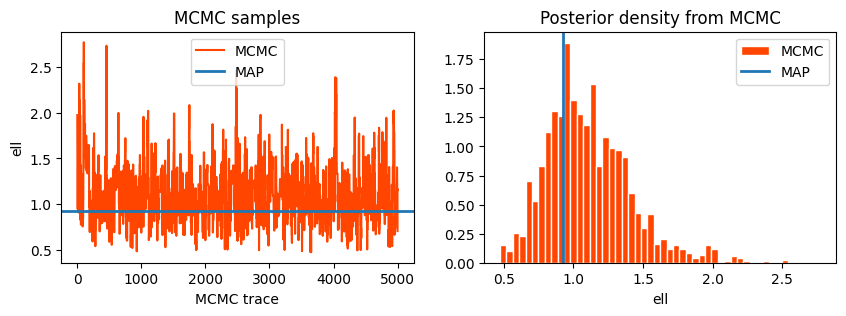

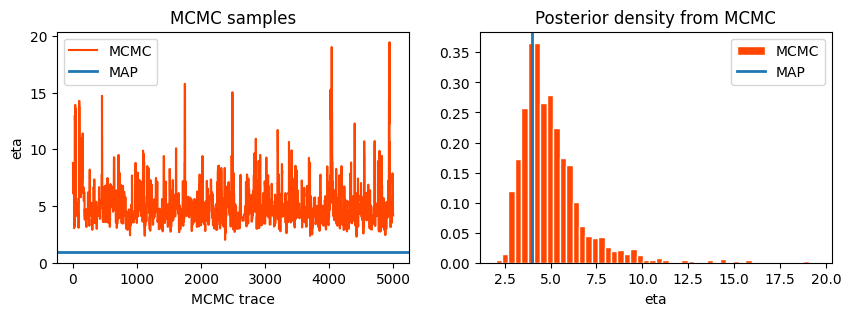

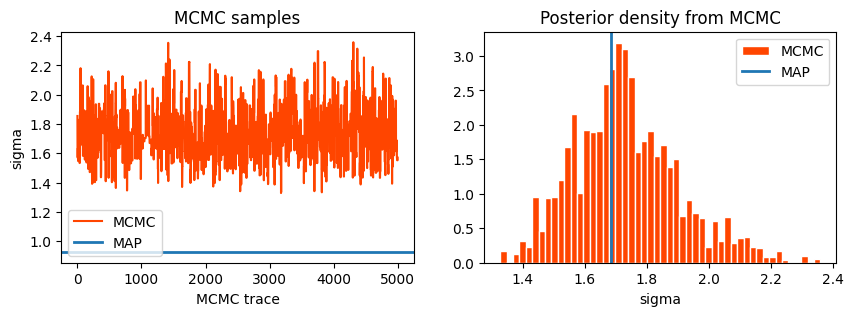

In [17]:
def plot_(param):
    traces = marginal_post.posterior[param].values.flatten()
    fig = plt.figure(figsize=(10,3))
    plt.subplot(121)
    plt.plot(traces, color='orangered', label='MCMC')
    plt.axhline(map_post['ell'], label='MAP', lw=2)
    plt.xlabel('MCMC trace')
    plt.title('MCMC samples')
    plt.ylabel(param)
    plt.legend()
    plt.subplot(122)
    plt.hist(traces, 50, color='orangered', edgecolor='w', label='MCMC', density=True)
    plt.axvline(map_post[param], label='MAP', lw=2)
    plt.xlabel(param)
    plt.title('Posterior density from MCMC')
    plt.legend()
    plt.show()
    
plot_('ell')
plot_('eta')
plot_('sigma')

In [18]:
# Test values
X_new = np.linspace(0, 20, 600)[:, None]

# add the GP conditional to the model, given the new X values
with model:
    f_pred = gp.conditional("f_pred", X_new)

with model:
    pred_samples = pm.sample_posterior_predictive(
        marginal_post.sel(draw=slice(0, 50)), var_names=["f_pred"] # using 50 samples from the chain
    )

Sampling: [f_pred]


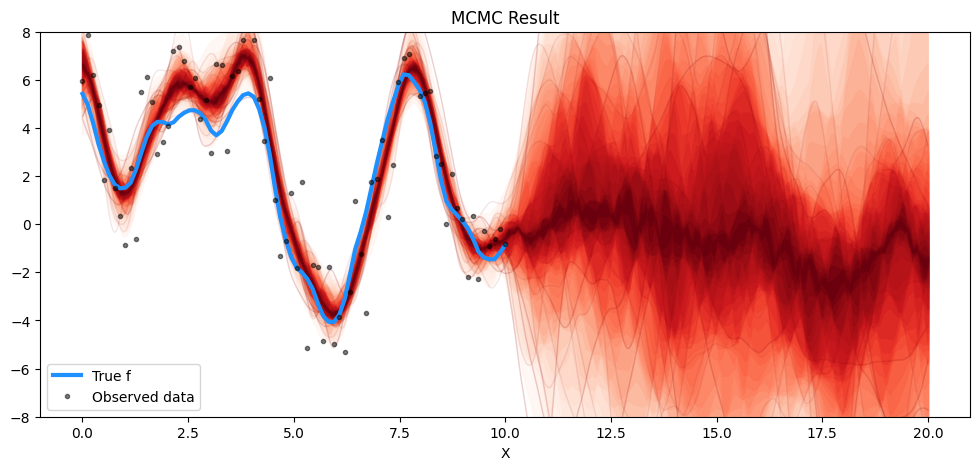

In [21]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc.gp.util import plot_gp_dist

f_pred_samples = az.extract(pred_samples, group="posterior_predictive", var_names=["f_pred"])
plot_gp_dist(ax, samples=f_pred_samples.T, x=X_new)

# plot the data and the true latent function
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f")
plt.plot(X, y, "ok", ms=3, alpha=0.5, label="Observed data")

# axis labels and title
plt.xlabel("X")
plt.ylim([-8, 8])
plt.title("MCMC Result")
plt.legend();